# Packages
Install and load important libraries

In [ ]:
!pip install shap

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
import seaborn as sns

from lightgbm.plotting import create_tree_digraph
import shap

from lightgbm import LGBMRegressor,plot_importance,plot_metric,plot_tree
from scipy import stats

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (25, 10)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
#https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather
!cp -r '/content/drive/MyDrive/.../dataset/' './'

cp: cannot open '/content/drive/MyDrive/Advanced Topics in ML Group Project/dataset/train.gsheet' for reading: Operation not supported


# Functions

Functions to be used through the pipeline.
Usage for both fixing the data and evaluating the results.

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    """
    It takes a dataframe, plots all the numerical columns against each other in a scatter matrix, and
    then plots the correlation coefficient on each plot
    
    :param df: The dataframe you want to plot
    :param plotSize: the size of the plot
    :param textSize: The size of the text in the scatter matrix
    """
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    #df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    """
    It takes a dataframe and a graph width and plots a correlation matrix of the dataframe
    
    :param df: The dataframe you want to plot
    :param graphWidth: The width of the plot in inches
    :return: The correlation matrix is being returned.
    """
    #filename = df.dataframeName
    #df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()

# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    """
    It plots the distribution of each column in the dataframe
    
    :param df: The dataframe you want to plot
    :param nGraphShown: The number of graphs to show
    :param nGraphPerRow: Number of graphs per row
    """
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

def diagnostic_plots(df, variable):
    """
    It takes a dataframe and a variable name as input, and plots a histogram, a Q-Q plot, and a boxplot
    of the variable
    
    :param df: the dataframe
    :param variable: the variable you want to plot
    """
    plt.figure(figsize=(17, 5))

    plt.subplot(1, 3, 1)
    sns.distplot(df[variable])
    plt.title('Histogram')
    
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    plt.subplot(1, 3, 3)
    sns.boxplot(x=df[variable])
    plt.title('Boxplot')
    
    plt.show()

def plotImp(model, X, num=20, fig_size=(20,10)):
    """
    It takes a trained model, a dataframe of features, and a number of features to plot, and then plots
    the feature importances
    
    :param model: the model you want to plot the feature importance for
    :param X: the dataframe containing the features
    :param num: number of features to plot, defaults to 20 (optional)
    :param fig_size: the size of the plot
    """
    X = X.drop(columns=['total load actual'])
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale=3)
    sns.barplot(x='Value', y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])

    plt.title('LightGBM Feature (avg over folds)')
    plt.tight_layout()
    plt.show()

def forecast_accuracy(forecast, actual):
    """
    The function takes in two arguments, forecast and actual, and returns a dictionary of metrics
    
    :param forecast: the predicted values
    :param actual: the actual values
    :return: A dictionary with the values of the different metrics.
    """
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)  # ME
    mae = np.mean(np.abs(forecast - actual))  # MAE
    mpe = np.mean((forecast - actual) / actual)  # MPE
    rmse = np.mean((forecast - actual) ** 2) ** .5  # RMSE

    return ({'mape': mape, 'me': me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse})

In [ ]:
def customise_data(data):
    """
    It takes the dataframe as input, creates a copy of it, and then creates a new column for each of the
    weather variables, which is the average of the weather variables for the 5 cities
    
    :param data: The dataframe that you want to customise
    :return: The dataframe with the columns: total load actual, temp, temp_min, temp_max, pressure,
    humidity, wind_speed, wind_deg, rain_1h, snow_3h, clouds_all, weather_id
    """
    df = data.copy()

    #df['temp'] = train_df_daily['Valencia_temp'], train_df_daily['Madrid_temp'], train_df_daily['Bilbao_temp'], train_df_daily['Barcelona_temp'], train_df_daily['Seville_temp']
    df['temp'] = df[['Valencia_temp', 'Madrid_temp', 'Bilbao_temp', 'Barcelona_temp', 'Seville_temp']].mean(axis=1)
    df['temp_min'] = df[['Valencia_temp_min', 'Madrid_temp_min', 'Bilbao_temp_min', 'Barcelona_temp_min', 'Seville_temp_min']].mean(axis=1)
    df['temp_max'] = df[['Valencia_temp_max', 'Madrid_temp_max', 'Bilbao_temp_max', 'Barcelona_temp_max', 'Seville_temp_max']].mean(axis=1)
    df['pressure'] = df[['Valencia_pressure', 'Madrid_pressure', 'Bilbao_pressure', 'Barcelona_pressure', 'Seville_pressure']].mean(axis=1)
    df['humidity'] = df[['Valencia_humidity', 'Madrid_humidity', 'Bilbao_humidity', 'Barcelona_humidity', 'Seville_humidity']].mean(axis=1)
    df['wind_speed'] = df[['Valencia_wind_speed', 'Madrid_wind_speed', 'Bilbao_wind_speed', 'Barcelona_wind_speed', 'Seville_wind_speed']].mean(axis=1)
    df['wind_deg'] = df[['Valencia_wind_deg', 'Madrid_wind_deg', 'Bilbao_wind_deg', 'Barcelona_wind_deg', 'Seville_wind_deg']].mean(axis=1)
    df['rain_1h'] = df[['Valencia_rain_1h', 'Madrid_rain_1h', 'Bilbao_rain_1h', 'Barcelona_rain_1h', 'Seville_rain_1h']].mean(axis=1)
    df['snow_3h'] = df[['Valencia_snow_3h', 'Madrid_snow_3h', 'Bilbao_snow_3h', 'Barcelona_snow_3h', 'Seville_snow_3h']].mean(axis=1)
    df['clouds_all'] = df[['Valencia_clouds_all', 'Madrid_clouds_all', 'Bilbao_clouds_all', 'Barcelona_clouds_all', 'Seville_clouds_all']].mean(axis=1)
    df['weather_id'] = df[['Valencia_weather_id', 'Madrid_weather_id', 'Bilbao_weather_id', 'Barcelona_weather_id', 'Seville_weather_id']].mean(axis=1)
    return df[['total load actual','temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'snow_3h', 'clouds_all', 'weather_id']]

def extract_from_date(data,time_column):
    """
    It takes a dataframe and a column name as input and returns a dataframe with the following columns:
    year, quarter, month, week, dayofweek, dayofmonth, day_name, is_weekend, is_year_start.
    
    :param data: the dataframe
    :param time_column: The column name of the date column in the dataframe
    :return: The dataframe with the new columns and without the columns 'day_name' and 'Date'
    """
    data["year"]=data[time_column].dt.year
    data["quarter"]=data[time_column].dt.quarter
    data["month"]=data[time_column].dt.month
    data["week"]=data[time_column].dt.isocalendar().week
    #data["hour"]=data[time_column].dt.hour
    #data["time"]=data[time_column].dt.time
    data['dayofweek'] = data[time_column].dt.dayofweek
    data["dayofmonth"]=data[time_column].dt.day
    data["day_name"]=data[time_column].dt.day_name()
    data['is_weekend'] = np.where(data['day_name'].isin(['Sunday', 'Saturday']), 1,0)
    data["is_year_start"]=np.where(data[time_column].dt.is_year_start, 1, 0)
    
    return data.drop(columns=['day_name', 'Date'])

def convert_data(data,step):
    """
    It takes the dataframe, shifts the target column by the number of steps, and returns the X and y
    numpy arrays
    
    :param data: the dataframe containing the data
    :param step: the number of days to look back
    :return: X, y, data, data2
    """
    data['shift_load'] = data['total load actual'].shift(step)
    data.reset_index(inplace = True)
    data.loc[0:(step-1),'shift_load'] = data.loc[0:(step-1),'total load actual']
    data2=data.copy()
    data.drop(columns=['Date'], inplace=True)
    X = data.loc[:, data.columns != 'total load actual'].to_numpy()
    y = data['total load actual'].to_numpy()
    return X, y, data, data2

# Load Data

In [ ]:
train_df = pd.read_csv('/content/dataset/train.csv', parse_dates=['Unnamed: 0'],index_col=['Unnamed: 0'])
test_df = pd.read_csv('/content/dataset/test.csv', parse_dates=['Unnamed: 0'],index_col=['Unnamed: 0'])

train_df['total load actual'] = train_df['total load actual'].astype('float64').fillna(method='bfill')
train_df.index = pd.to_datetime(train_df.index, utc='True')

test_df['total load actual'] = test_df['total load actual'].astype('float64').fillna(method='bfill')
test_df.index = pd.to_datetime(test_df.index, utc='True')

train_df_daily = train_df.copy()
test_df_daily = test_df.copy()

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_df_daily)
train_data_scaled = scaler.transform(train_df_daily)
train_df_daily = pd.DataFrame(train_data_scaled, columns=train_df.columns)
train_df_daily['Date']=train_df.index
test_data_scaled = scaler.transform(test_df_daily)
test_df_daily = pd.DataFrame(test_data_scaled, columns=test_df.columns)
test_df_daily['Date']=test_df.index

test_df_daily.set_index('Date', inplace=True)
train_df_daily.set_index('Date', inplace=True)

In [ ]:
# Fix columns names to a standard convention, remove spaces from the names etc.
fix_columns = ['total load actual', 'Valencia_temp', 'Valencia_temp_min',
       'Valencia_temp_max', 'Valencia_pressure', 'Valencia_humidity',
       'Valencia_wind_speed', 'Valencia_wind_deg', 'Valencia_rain_1h',
       'Valencia_rain_3h', 'Valencia_snow_3h', 'Valencia_clouds_all',
       'Valencia_weather_id', 'Madrid_temp', 'Madrid_temp_min',
       'Madrid_temp_max', 'Madrid_pressure', 'Madrid_humidity',
       'Madrid_wind_speed', 'Madrid_wind_deg', 'Madrid_rain_1h',
       'Madrid_rain_3h', 'Madrid_snow_3h', 'Madrid_clouds_all',
       'Madrid_weather_id', 'Bilbao_temp', 'Bilbao_temp_min',
       'Bilbao_temp_max', 'Bilbao_pressure', 'Bilbao_humidity',
       'Bilbao_wind_speed', 'Bilbao_wind_deg', 'Bilbao_rain_1h',
       'Bilbao_rain_3h', 'Bilbao_snow_3h', 'Bilbao_clouds_all',
       'Bilbao_weather_id', 'Barcelona_temp', 'Barcelona_temp_min',
       'Barcelona_temp_max', 'Barcelona_pressure', 'Barcelona_humidity',
       'Barcelona_wind_speed', 'Barcelona_wind_deg', 'Barcelona_rain_1h',
       'Barcelona_rain_3h', 'Barcelona_snow_3h', 'Barcelona_clouds_all',
       'Barcelona_weather_id', 'Seville_temp', 'Seville_temp_min',
       'Seville_temp_max', 'Seville_pressure', 'Seville_humidity',
       'Seville_wind_speed', 'Seville_wind_deg', 'Seville_rain_1h',
       'Seville_rain_3h', 'Seville_snow_3h', 'Seville_clouds_all',
       'Seville_weather_id']

train_df_daily.columns = fix_columns
test_df_daily.columns = fix_columns

In [ ]:
train_df = customise_data(train_df_daily)
test_df = customise_data(test_df_daily)

# Get CLND features to use for the models
train_df['Date'] = train_df.index
test_df['Date'] = test_df.index
train_df = extract_from_date(train_df, 'Date')
test_df = extract_from_date(test_df, 'Date')

In [ ]:
#plotCorrelationMatrix(train_df.drop(columns=['total load actual']), 8)

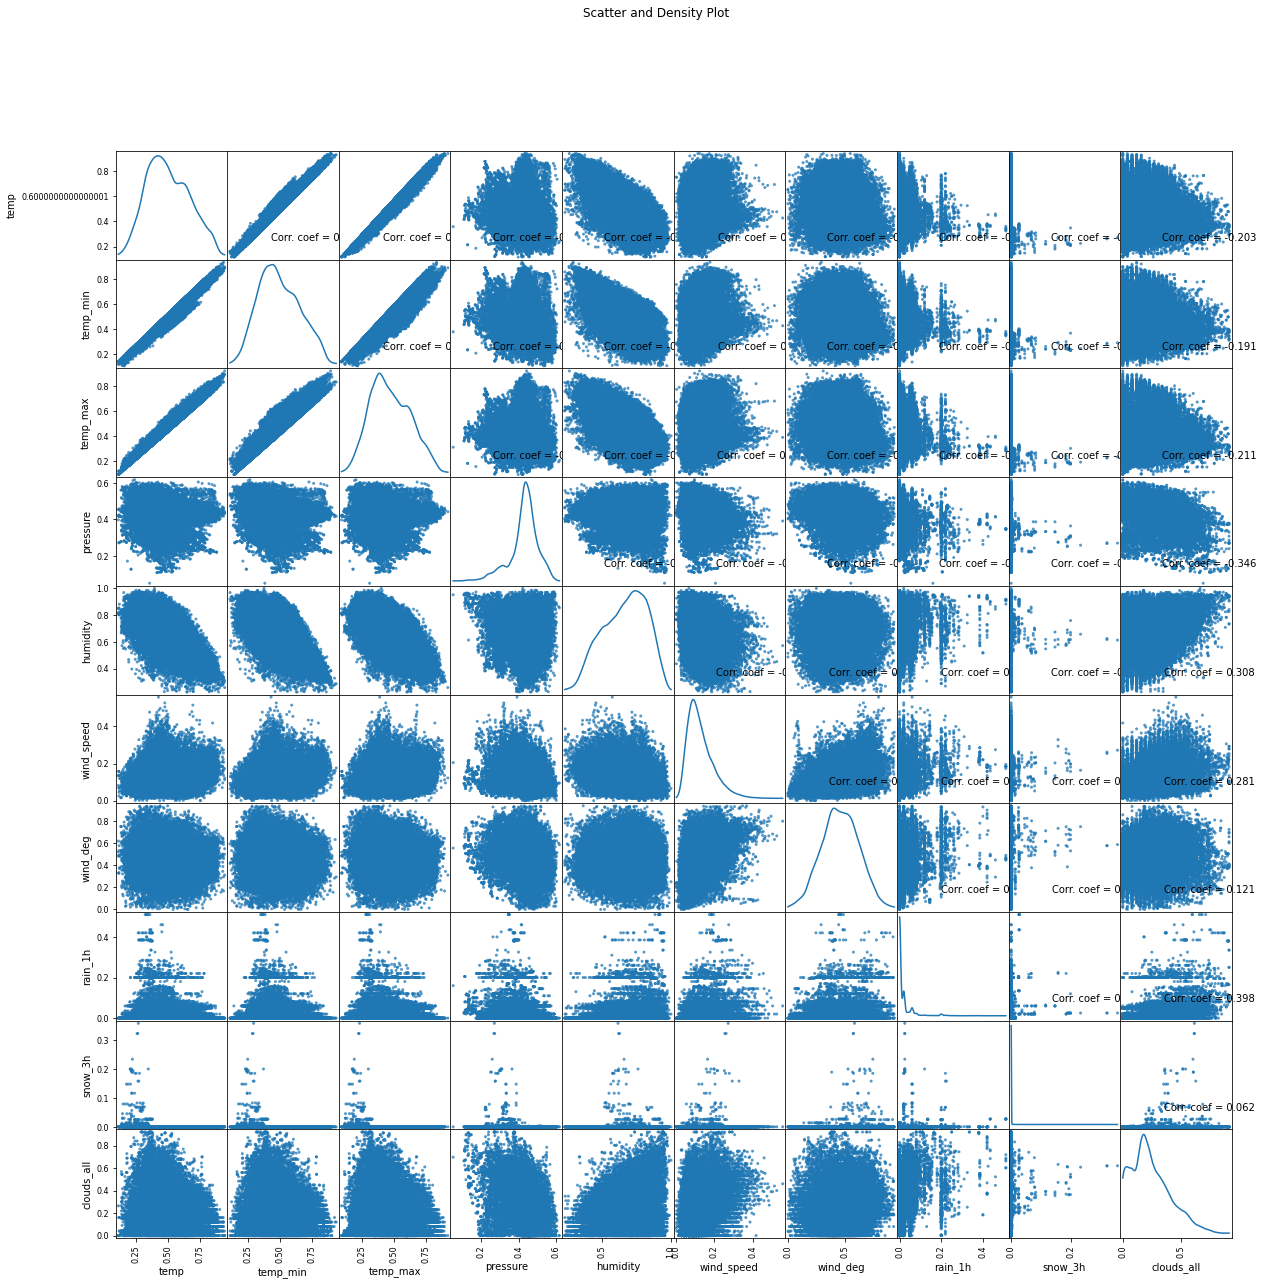

In [ ]:
plotScatterMatrix(train_df.drop(columns=['total load actual']), 20, 10)

In [ ]:
# Create shift_load by a 24 hours step
step = 24
cols = ['total load actual', 'temp_min',	'temp_max', 'pressure', 'humidity', 'dayofweek', 'dayofmonth']
train = train_df[cols]
test = test_df[cols]
X_train, y_train, train_data, train_data_2 = convert_data(train,step)
X_test, y_test, test_data, test_data_2 = convert_data(test,step)

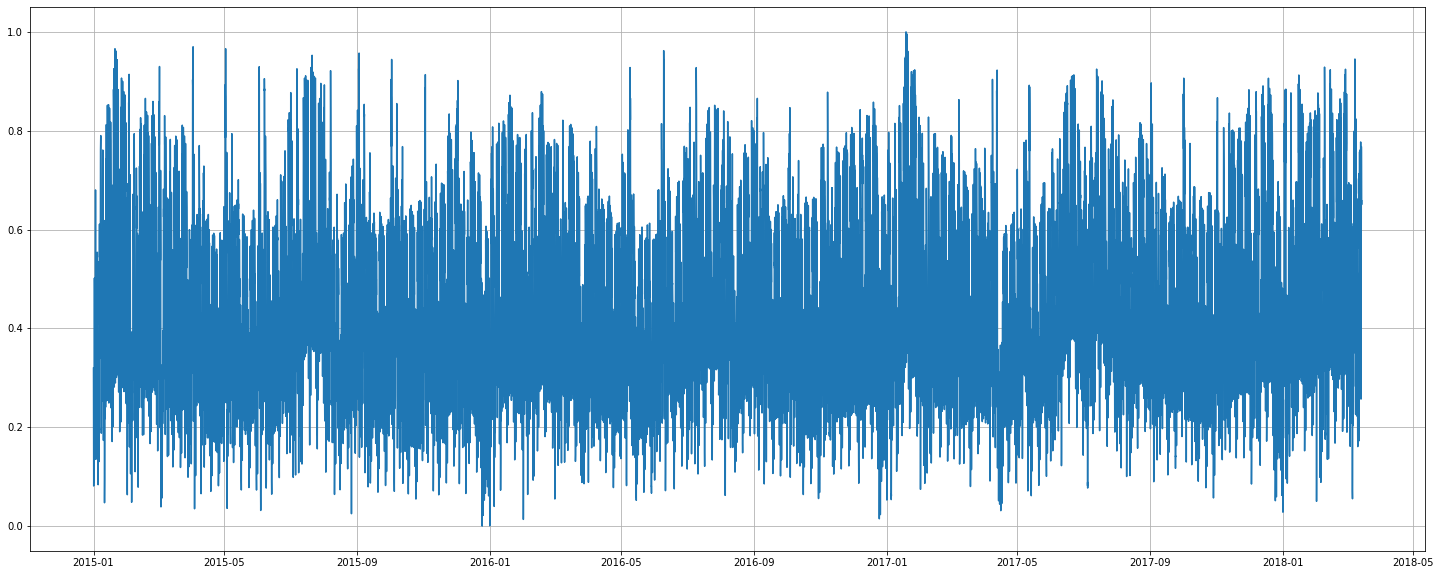

In [ ]:
yAxis = train_df['total load actual']
xAxis = train_df.index
plt.plot(xAxis, yAxis)
plt.grid()
plt.show()

# Grid Search

In [ ]:
# Grid Search for the best model

gridParams = {
    'metric': ['rmse'],
    'boosting_type': ['gbdt'],
    'num_leaves': [40, 45],
    'max_depth': [-1],
    'n_estimators': [40, 45],
    'learning_rate': [0.05, 0.1],
    'objective': ['regression'],
    'subsample': [0.8], 
    'colsample_bytree':[0.9], 
    'reg_alpha': [0.9, 0.6, 0.4, 0.8], 
    'reg_lambda': [0.2, 0.1]
}

gbm = lgb.LGBMRegressor()
grid = GridSearchCV(gbm, gridParams, verbose=1, cv=10, n_jobs=-1, refit=True)

grid.fit(X_train, y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


GridSearchCV(cv=10, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'], 'colsample_bytree': [0.9],
                         'learning_rate': [0.05, 0.1], 'max_depth': [-1],
                         'metric': ['rmse'], 'n_estimators': [40, 45],
                         'num_leaves': [40, 45], 'objective': ['regression'],
                         'reg_alpha': [0.9, 0.6, 0.4, 0.8],
                         'reg_lambda': [0.2, 0.1], 'subsample': [0.8]},
             verbose=1)

In [ ]:
print(grid.best_params_)
print(grid.best_score_)

{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'rmse', 'n_estimators': 45, 'num_leaves': 45, 'objective': 'regression', 'reg_alpha': 0.6, 'reg_lambda': 0.1, 'subsample': 0.8}
0.688232780313764


# LGBMRegressor model training

Using the parameters found from grid search, fit the model

In [ ]:
params = {'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'rmse', 'n_estimators': 45, 'num_leaves': 45, 'objective': 'regression', 'reg_alpha': 0.6, 'reg_lambda': 0.1, 'subsample': 0.8}

list_of_tuples = [(X, y) for X, y in zip(X_test, y_test)]

#gbm = lgb.LGBMRegressor(**grid.best_params_, eval_list=list_of_tuples)
gbm = lgb.LGBMRegressor(**params, eval_list=list_of_tuples)

gbm.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.9,
              eval_list=[(array([ 0.44993367,  0.42574966,  0.31081332,  0.72807098,  2.        ,
       14.        ,  0.7400975 ]),
                          0.7400975015234612),
                         (array([ 0.44519657,  0.40979434,  0.30166658,  0.74516917,  2.        ,
       14.        ,  0.79172108]),
                          0.7917210759989552),
                         (array([ 0.43613391,  0.40157208,  0.30642091,  0.76407232,  2.        ,
       14.        ,  0.74101158]),
                          0.741011578305911),
                         (array([ 0.43630549,  0.38990935,...
                         (array([ 0.39702085,  0.34940896,  0.33889895,  0.68789919,  3.        ,
       15.        ,  0.6218769 ]),
                          0.6242273874815008),
                         (array([ 0.38327501,  0.33722138,  0.34672541,  0.71317361,  3.        ,
       15.        ,  0.5       ]),
                          0.4920780012187691),
   

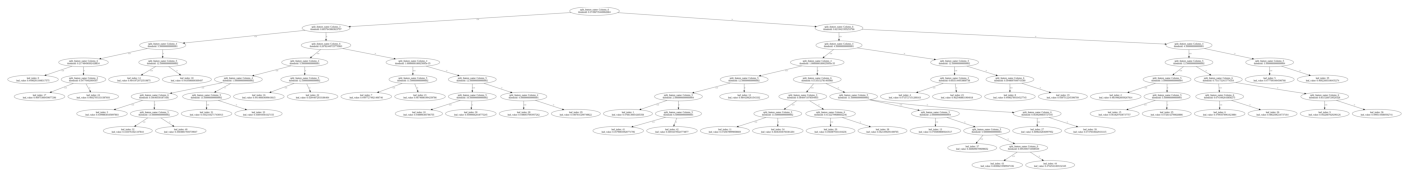

In [ ]:
create_tree_digraph(gbm)
plot_tree(gbm,tree_index=0)

In [ ]:
y_pred = gbm.predict(X_test)

# Evaluation

Evaluate result through metrics like mse and mape.
High level evaluation with plots

In [ ]:
forecast_accuracy(y_pred, y_test)

{'mae': 0.07346479540506247,
 'mape': 0.2080433045292824,
 'me': -0.010934998668360668,
 'mpe': 0.06681103529257787,
 'rmse': 0.10858461140333082}

### Comparing results with other models

In [ ]:
df1 = train_data_2.copy()
df1.set_index('Date', inplace=True)
df2 = test_data_2.copy()
df2.set_index('Date', inplace=True)
df1['predictions'] = 0
df2['predictions'] = y_pred
result = pd.concat([df1, df2], axis=0)
result['date'] = result.index
results = result[['date', 'total load actual', 'predictions']]

In [ ]:
import plotly.express as px

fig = px.line(res, x="Date", y=res.columns,
              hover_data={"Date": "|%B %d, %Y"},
              title='Actuals vs Predictions')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
    ticklabelmode="period")
fig.show()

# More info for the data

## Heatmap with mask

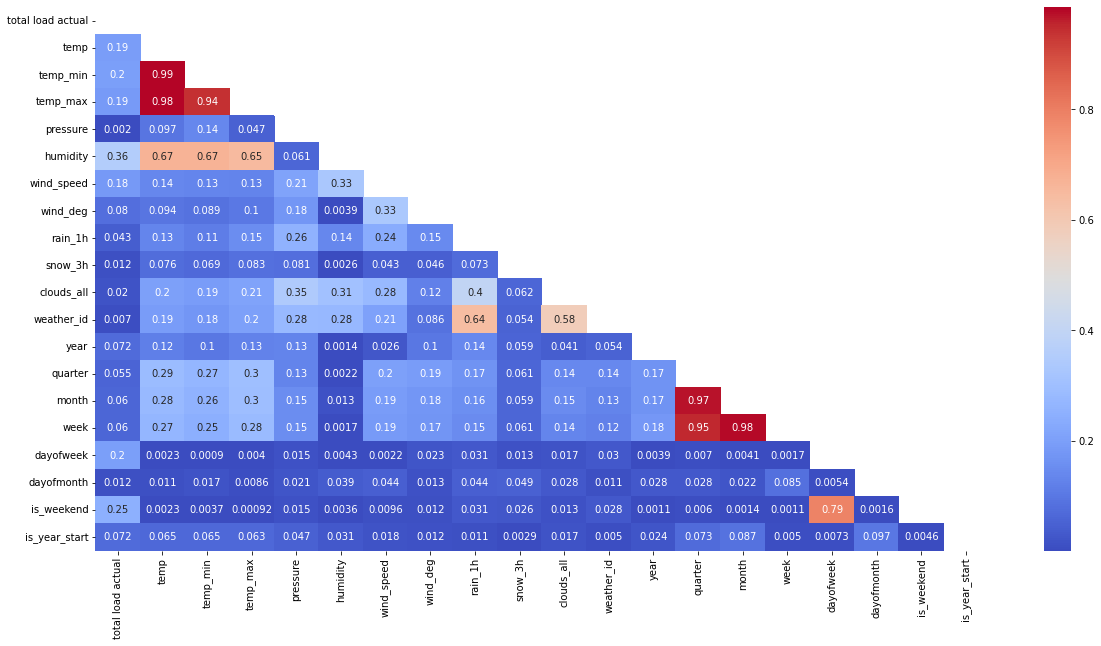

In [ ]:
plt.figure(figsize=(20,10));
corr= train_df.corr().abs()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)
# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix, cmap="coolwarm")

## Diagnostic Plots

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


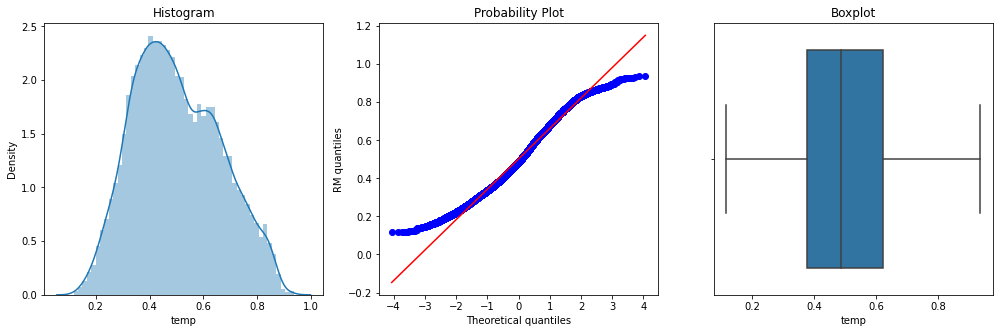

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


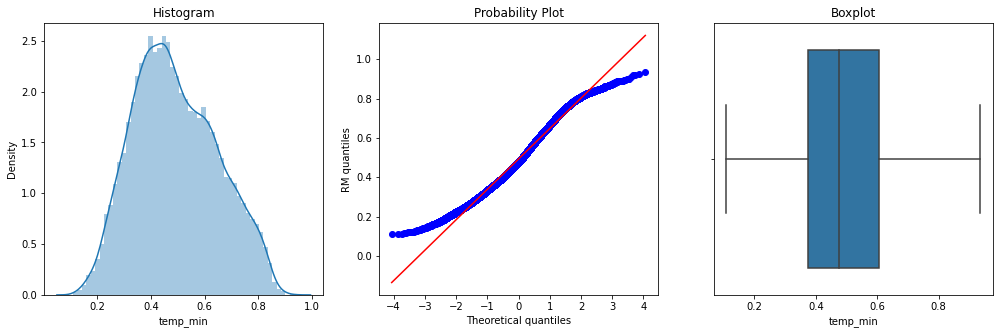

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


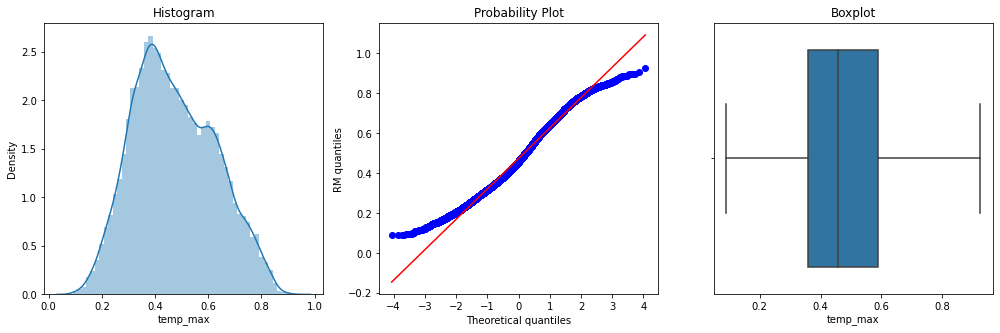

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


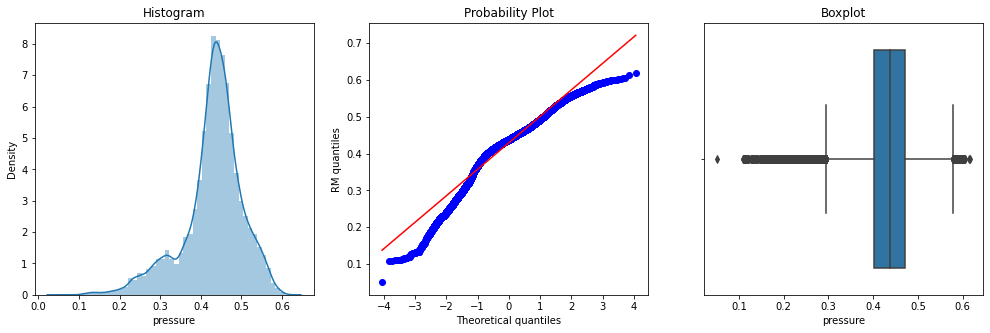

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


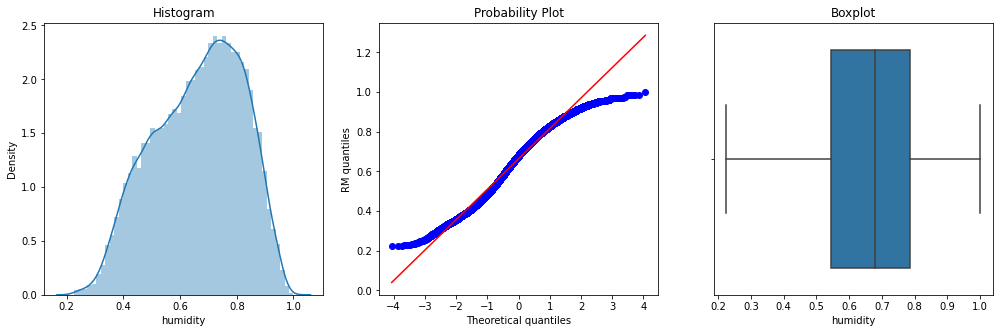

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


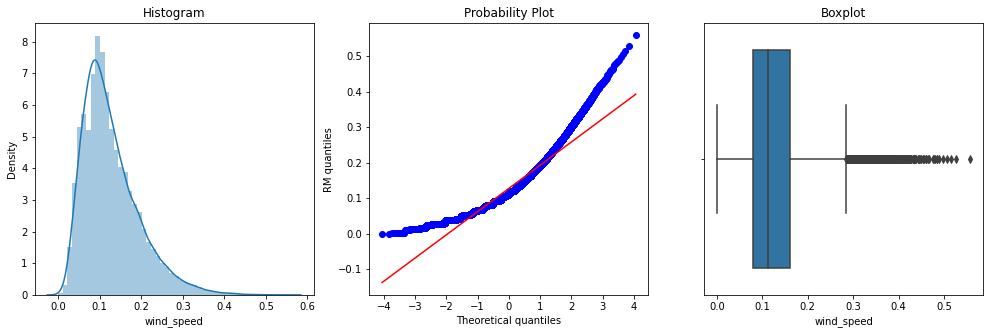

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


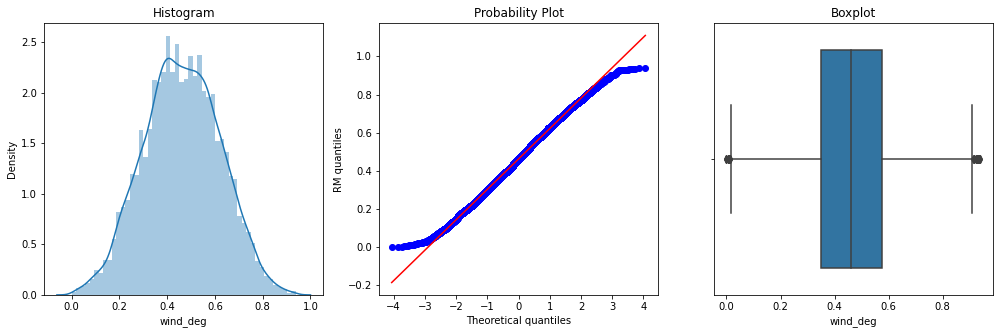

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


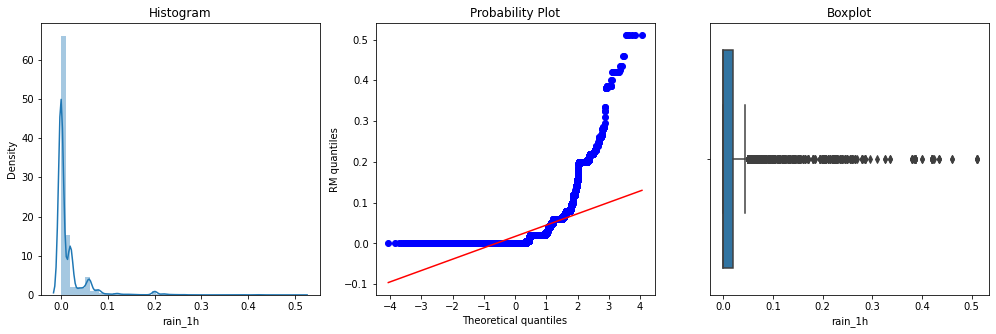

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


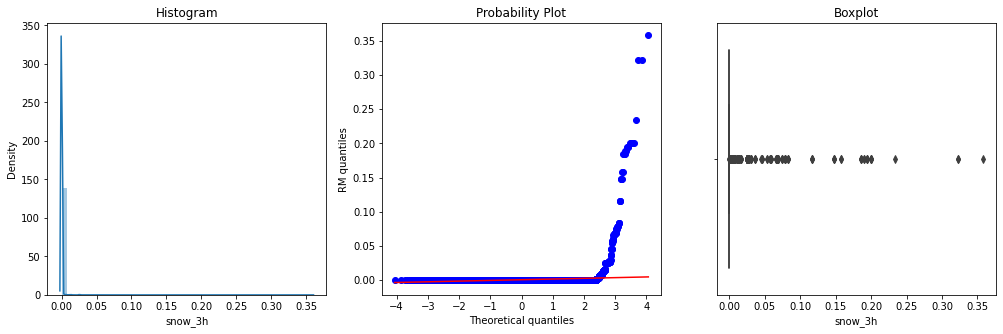

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


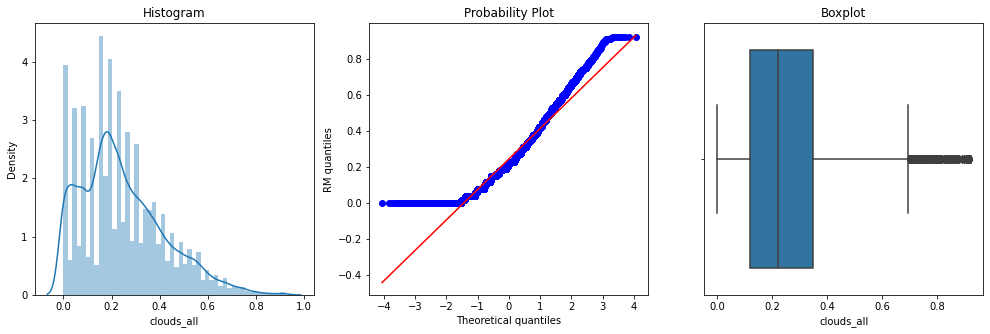

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


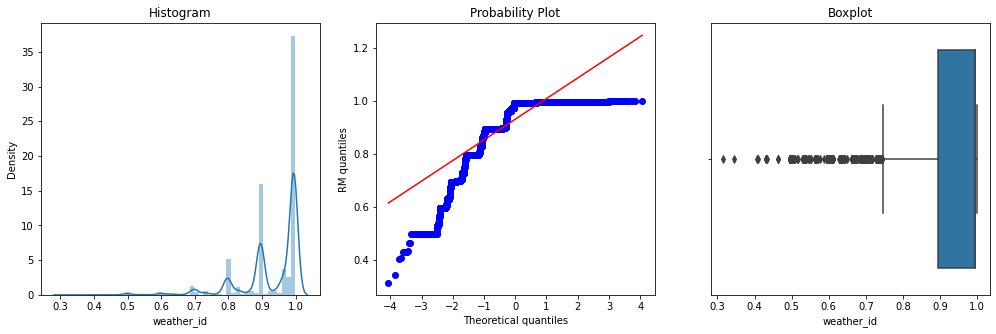

In [ ]:
# Remove clnd features before plotting the next diagnostic plots
cols = ['total load actual', 'year', 'quarter', 'month', 'week', 'dayofweek', 'dayofmonth', 'is_weekend', 'is_year_start']
for col in train_df.drop(columns=cols).columns.to_list():
        diagnostic_plots(train_df.drop(columns=['total load actual']),col)

## SHAP Plot

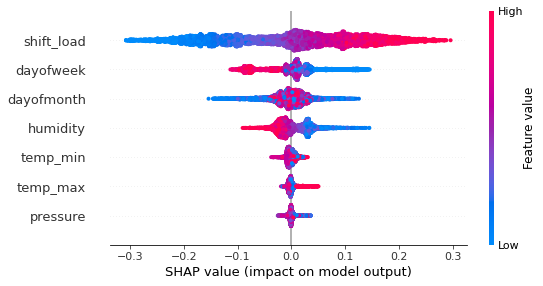

In [ ]:
cols = ['temp_min',	'temp_max', 'pressure', 'humidity', 'dayofweek', 'dayofmonth', 'shift_load']
df = pd.DataFrame(X_test, columns = cols)

explainer = shap.TreeExplainer(gbm)

shap_values = explainer.shap_values(df)

shap.summary_plot(shap_values, df)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)

shap.plots.force is slow for many thousands of rows, try subsampling your data.


## Feature Importance

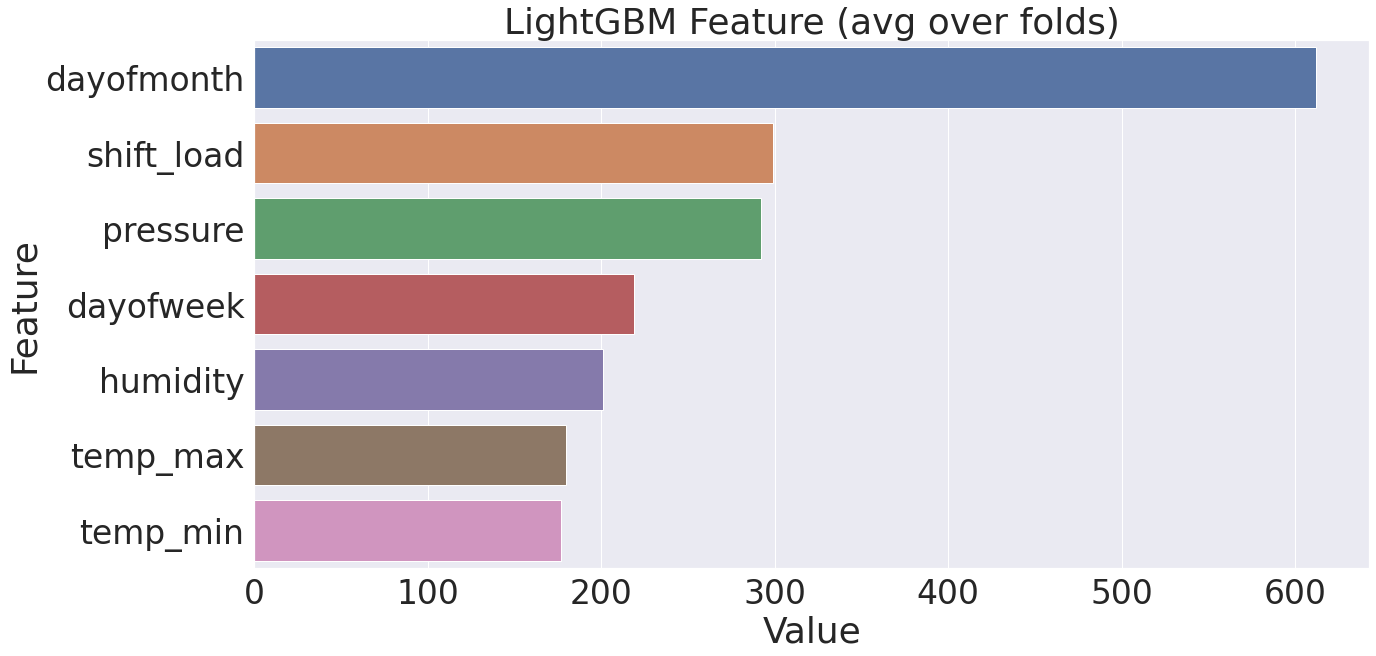

In [ ]:
cols = ['temp_min',	'temp_max', 'pressure', 'humidity', 'dayofweek', 'dayofmonth','shift_load']
df = pd.DataFrame(X_train, columns = cols)
df['total load actual'] = train_df['total load actual']
plotImp(gbm, df)